# Intro
## Problem Statement
The goal of this project is to apply Deep Learning techniques to generate semantic segmentation masks for everyday images.  The data is provided by the PASCAL VOC competition, featuring images and masks for 20 different types of objects (cows, cars, cats, etc.). Our aim is to build a model that successfully generates an image segmentation mask given an input image.  Using the TensorFlow API, a fully convolutional U-Net is constructed by building off of the published MobileNet2 model. Potential applications of such a model include self-driving car and medical imaging technologies. 


## Image Segmentation
Image segmentation refers to the task of learning a "mask" for an input image. The mask is a pixel-wise classification mask, such that every pixel in the picture is predicted to be part of a single category. 

![title](notebook_pics/img_seg2.png)

Above we can see two different types of segmentation: instance and semantic. Instance segmentation tasks aim to not only label each object, but also differentiate between objects of the same class. Semantic segmentation only aims to label objects and non-objects/background. For this project, I will be focusing on a *semantic* segmentation problem. 

## Approach
Semantic segmentation represents a new challenge in terms of model construction. This problem differs significantly from previously seen simple classification problems. In a simple classification problem, we only assign one label to each image (i.e. cat or dog). However, in semantic segmentation, we could have any number of object classes present together in the same photo. So how do we construct a deep learning model with a variable number of labels for each picture? 

In order to properly represent a multi-class image, we will rely heavily on one-hot encodings and sparse matrices. In the example below, we can see that the image contains five different classes of objects. Therefore, every pixel in the image receives a label according to the class it belongs.

![title](notebook_pics/one_hot.png)

# Imports

In [1]:
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Conv2DTranspose, Input, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import losses

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from IPython.display import clear_output

plt.style.use('fivethirtyeight')

# Data Processing
Let's start by simply building our datapipeline. 

Note: I began by downloading the data from Pascal VOC competition website, then placing and unzipping the file in a `data` directory directly outside of my current directory. 
http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit

Pascal gives us more images than it has masks for, so we have to make sure we only load images that have masks. 


In [2]:
home, d, v = ['..', 'data', 'VOC2012']
voc_dir = os.path.join(home, d, v)
images = 'JPEGImages'
masks = 'SegmentationClass'

images_dir = os.path.join(voc_dir, images)
masks_dir = os.path.join(voc_dir, masks)

In [3]:
png = '.png'
jpeg = '.jpg'

fnames = os.listdir(masks_dir)
# generate lists of file names
mask_fnames = [os.path.join(masks_dir, i) for i in fnames]
img_fnames = [os.path.join(images_dir, i.replace(png, jpeg)) for i in fnames]


In [4]:
mask_fnames[:3]

['../data/VOC2012/SegmentationClass/2007_003000.png',
 '../data/VOC2012/SegmentationClass/2007_004009.png',
 '../data/VOC2012/SegmentationClass/2011_002623.png']

In [5]:
img_fnames[:3]

['../data/VOC2012/JPEGImages/2007_003000.jpg',
 '../data/VOC2012/JPEGImages/2007_004009.jpg',
 '../data/VOC2012/JPEGImages/2011_002623.jpg']

Now we will preprocess the data. In order to maintain integrity of the masks we use the `nearest` method when resizing. This ensures that the mask does not have pixel values that do not map to a class. 

In [6]:
# processing utils
def process_img(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (128, 128)) 
    
    return img
    
def process_mask(mask):
    mask = tf.io.read_file(mask)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, (128, 128), method='nearest')
    mask = tf.image.rgb_to_grayscale(mask)
#     mask = tf.cast(mask, tf.float32)/ 255.
    
    return mask

In [7]:
masks = [process_mask(mask) for mask in mask_fnames]
images = [process_img(img) for img in img_fnames]


____

Since our data are in list format, let's split the data into our train, validation, and test sets. Then with the splits, we will do the final bit of processing on each set of data in order to be fed into a TensorFlow model.

In [8]:
x, xtest, y, ytest = train_test_split(images, masks, random_state=10, test_size=0.2)
xtrain, xval, ytrain, yval = train_test_split(x, y, random_state=10, test_size=0.3)
len(xtrain), len(ytrain), len(xval), len(yval), len(xtest), len(ytest)

(1631, 1631, 699, 699, 583, 583)

In [9]:
# tf will complain if we pass lists to our model
# we will stack the lists into Tensors
xtrain = tf.stack(xtrain)
ytrain = tf.stack(ytrain)

xval = tf.stack(xval)
yval = tf.stack(yval)

xtest = tf.stack(xtest)
ytest = tf.stack(ytest)

In [10]:
ytrain.shape

TensorShape([1631, 128, 128, 1])

Now that we have all the images and masks loaded, I'd like to expanding the channels on the masks to the number of classes (i.e. 20). This way, each mask will be (128, 128, 20) after preprocessing. This will allow our targets to be treated as one-hot encodings of the original mask. 

Each channel will represent pixels from a *single* class or 0. Then, when creating our mask, we can use argmax to return the correct class value for each pixel. 

Since we are really just doing a classification problem, this will allow us to use categorical cross entropy effectively as a loss function.

First let's just confirm that there are only 20 unique pixel values in our masks.

In [11]:
# check only be 21 unique numbers in the masks...
len(np.unique(ytrain))

20

In [12]:
# a quick check to make sure each pixel in train masks is the same as those in the test masks
np.unique(ytrain) == np.unique(ytest)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Let's start by creating a dictionary that maps from the unique pixel values to class values (0 -> 20). 

In [13]:
pix2class = {k: v for k, v in zip(np.unique(ytrain), range(21))}
class2pix = {v: k for k, v in zip(np.unique(ytrain), range(21))}


Now we convert the pixel values of the mask to their class value. 

In [14]:
####################################################
# vectorizing this function makes it run much faster
def f(x):
    '''
    converts pixels to classes
    '''
    return pix2class[x]
pix2class_f = np.vectorize(f)
####################################################

In [15]:
yval2 = tf.stack([pix2class_f(n.numpy()) for n in yval])
ytrain2 = tf.stack([pix2class_f(n.numpy()) for n in ytrain])
ytest2 = tf.stack([pix2class_f(n.numpy()) for n in ytest])

Now the masks are represented by a single channel of class values. Let's create a sparse matrix.

In [16]:
ytrain2.shape

TensorShape([1631, 128, 128, 1])

In [17]:
yval_cat = tf.keras.utils.to_categorical(yval2)
ytrain_cat = tf.keras.utils.to_categorical(ytrain2)
ytest_cat = tf.keras.utils.to_categorical(ytest2)


In [18]:
ytrain_cat.shape

(1631, 128, 128, 20)

In [19]:
ytrain2 = tf.cast(ytrain2, tf.float32)

yval2 = yval2[:, :, :, 0]
ytest2 = ytest2[:, :, :, 0]

_________

Our data is finally ready for modeling. We will create `ImageDataGenerator` for both our input images and masks, which will help us augment our training data since we only have ~1500 images with masks.

In [20]:
BATCH_SIZE = 32
# create a data generator, because there aren't enough training images
gen_args = dict(rotation_range=.2, width_shift_range=0.1, 
               height_shift_range=0.1, shear_range=0.2, 
                zoom_range=0.3, fill_mode='nearest',
                horizontal_flip=True)

image_gen = ImageDataGenerator(**gen_args)
mask_gen= ImageDataGenerator(**gen_args)

image_gen.fit(xtrain, seed=10)
mask_gen.fit(ytrain_cat, seed=10)

IM_GEN = image_gen.flow(xtrain, batch_size=BATCH_SIZE, shuffle=True, seed=10)
MASK_GEN = mask_gen.flow(ytrain_cat, batch_size=BATCH_SIZE, shuffle=True, seed=10)

# the generator messes with our labels, so we need to make sure they are right
train_gen = (batch for batch in zip(IM_GEN, MASK_GEN))


/Users/wyssuser/anaconda3/envs/cs109b/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1631, 128, 128, 20) (20 channels).
  ' channels).')
/Users/wyssuser/anaconda3/envs/cs109b/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1631, 128, 128, 20) (20 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


After a lot of trial and error, I found that running our masks through the ImageDataGenerator significantly altered pixel values and threw of our masking schema. To combat this, I built a second generator, which yields a *corrected* batch of masks, which are more suitable for training. The generator will provide unlimited access to newly generated images and masks.

In [21]:
def correct_gen(generator):
    '''
    yields images BS, 128, 128, 3
           masks BS, 128, 128, 20
    '''
    while True:
        images, masks = next(generator)
        if masks.shape[0] != BATCH_SIZE:
            images, masks = next(generator)
            masks = tf.argmax(masks, axis=-1)
            masks = tf.keras.utils.to_categorical(masks)
        yield images, masks
        
train_gen2 = correct_gen(train_gen)

# Images
## Utils
We are going to want to view our images in a couple of different place in the notebook, so to make it easier we will write a few utility functions that will help us visualize our images and masks.

In [22]:
# viz. utils
def f2(x):
    '''
    convert classes to pixels
    '''
    return class2pix[x]
class2pix_f = np.vectorize(f2)

##############################

def create_mask(predictions):
    '''
    param: sparse mask(s), shape=?, 128, 128, 18
    
    returns: pixel wise mask(s), shape==?, 128, 128
        pixels: 0 -> 255
    '''
    mask = tf.argmax(predictions, axis=-1) # -> ? 128, 128
    mask = class2pix_f(mask.numpy())
    return mask

##############################

def show_example(img_list):
    '''
    original.shape == 128, 128, 3
    mask.shape == 128, 128, 18
    pred.shape == 128, 128, 18
    '''
    titles = ['Original', 'Mask', 'Predicted']
    
    fig, ax = plt.subplots(1, len(img_list), figsize=(10,10))
    
    ax[0].set_title(titles[0])
    ax[0].imshow(img_list[0])
    ax[0].axis('off')
    
    mask = create_mask(img_list[1])
    ax[1].imshow(mask, vmin=0, vmax=255)
    ax[1].set_title(f'Mask')
    ax[1].axis('off')
    
    if len(img_list)==3:
        i = 2
        pred = create_mask(img_list[2])
        ax[i].imshow(pred, vmin=0, vmax=255)
        ax[i].set_title(f'Predicted')
        ax[i].axis('off')
        

Let's take a peak at a few images and their masks to make sure everything looks good.

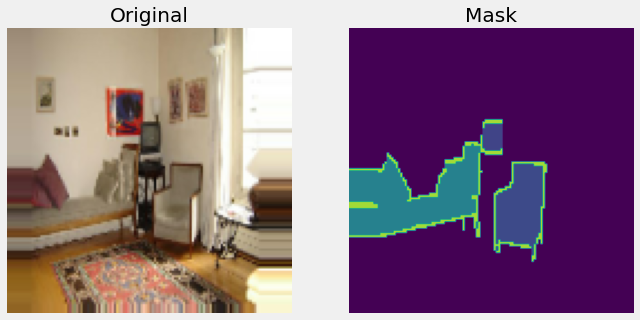

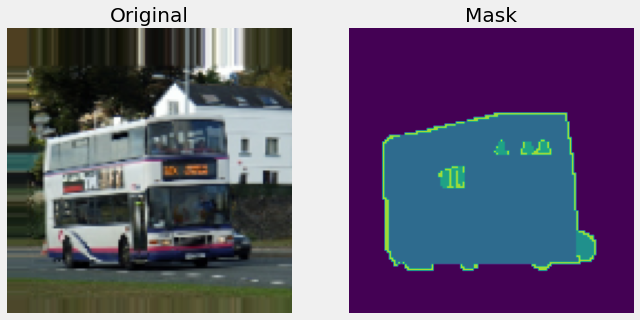

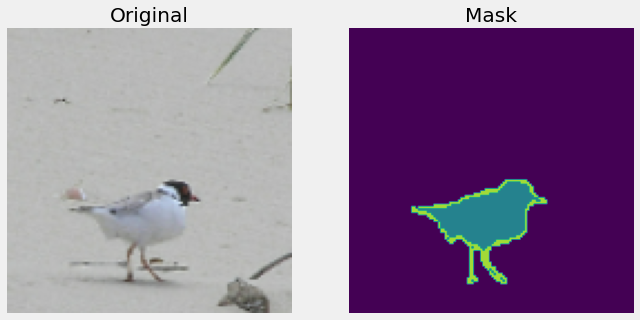

In [23]:
image_batch, mask_batch = next(train_gen2)

for i in range(3):
    show_example([image_batch[i], mask_batch[i]])


# Modeling 
The general approach to modeling will be to construct a U-Net. This is similar to an autoencoder, but instead of attempting to reproduce the input we will generate a mask for our input image. The U-Net will consist of an encoder, which narrows down to a bottleneck, followed by a decoder, which expands the feature maps provided by the encoder until we have feature maps equalling the size of our input. 

## Encoding with Transfer Learning
We will rely on transfer learning to do some of the heavy lifting here. MobileNetV2 is an already trained U-Net. However, since *our* goal differs from the goal of MobileNetV2, we will only use the weights and architecture from MobileNetV2's encoder. We set our output channels to 20 because our outputs will be sparse matrices where each pixel has a class score 1 through 20 (i.e. shape 128x128x20). 

In [24]:
OUTPUT_CHANNELS = 20 # 20 classes 
NUM_CLASSES = 20

In [25]:
# load base for transfer
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


## Decoding with Transpose Convolutions
Ater the downsampling, we will use the `upsample` function to iteratively build larger and larger feature maps.

In [26]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    """Upsamples an input.
    Conv2DTranspose => Batchnorm => Dropout => Relu
    Args:
        filters: number of filters
        size: filter size
        norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
        apply_dropout: If True, adds the dropout layer
    Returns:
        Upsample Sequential Model
        """

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
#                                       kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())

    return result


In [27]:
up_stack = [
    upsample(512, 3, apply_dropout=True),  # 4x4 -> 8x8
    upsample(256, 3, apply_dropout=True), # 8x8 -> 16x16
    upsample(128, 3, apply_dropout=True),  # 16x16 -> 32x32
    upsample(64, 3, apply_dropout=True),   # 32x32 -> 64x64
]

## Build Model
Now that all of our layers are defined, we will connect them with the `unet_model` function. Here we are utilizing "skip connections", which is when feature maps "skip" layers of the model. As our feature maps are upsampled, we will continually add additional feature map outputs from the MobileNetV2 base.

In [28]:
def unet_model(output_channels):
    inputs = Input(shape=[128, 128, 3])
    x = inputs
    
    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, padding='same')  #64x64 -> 128x128
        # I added the softmax
    x = last(x)
#     x = tf.keras.activations.softmax(x, axis=-1)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [29]:
model = unet_model(OUTPUT_CHANNELS)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Model)                   [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[1][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[1][3]                

## Model Visualization
### Architecture
It's always helpful to actually *see* how the model is designed. 

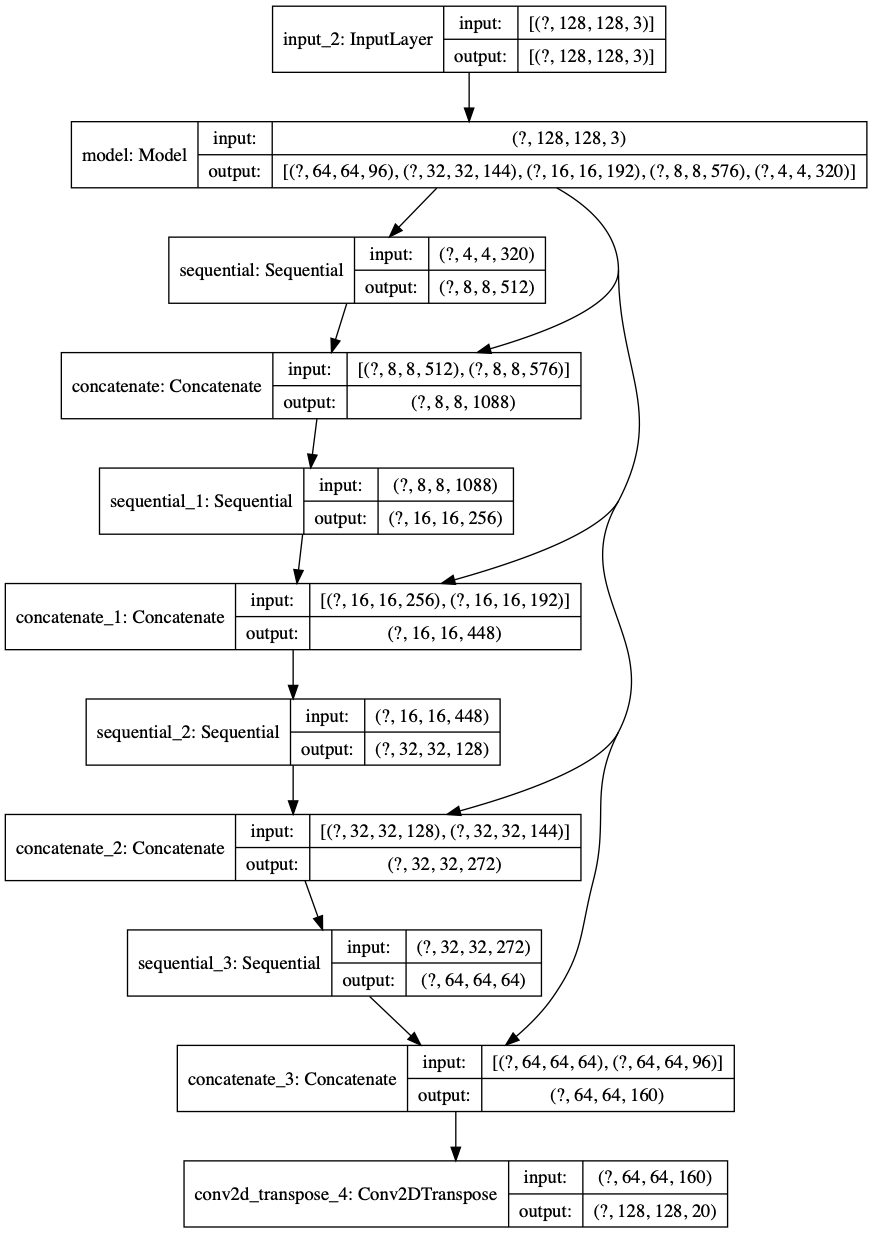

In [31]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Naive Predictions
Now that the model architecture is in place, we can use it to make naive predictions. Let's see what our (mostly) untrained model predicts for the feature maps. 

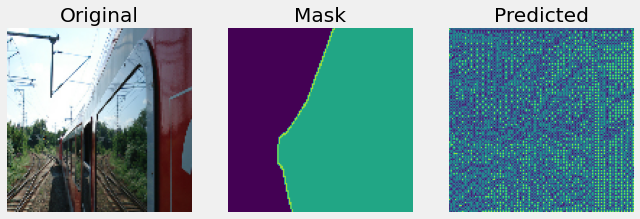

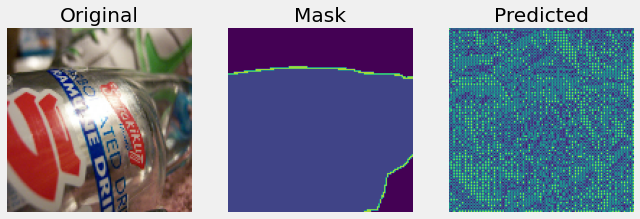

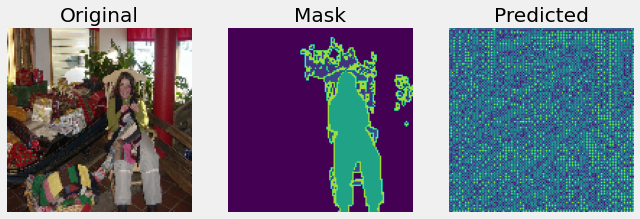

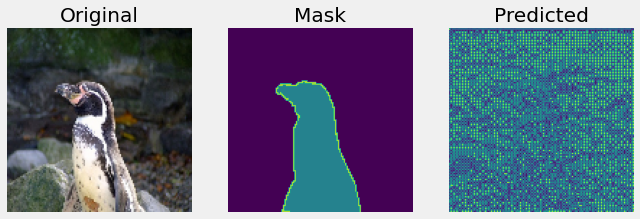

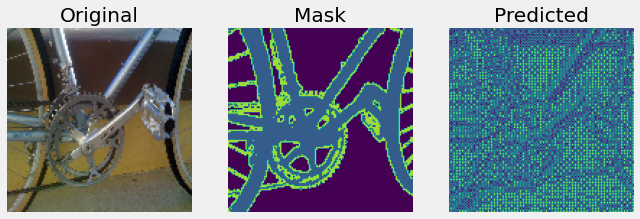

In [32]:
start = 0
end = 5
image_batch, mask_batch = xtest[start:end], ytest_cat[start:end]

# preds is 5, 128, 128, 19
preds = model.predict(image_batch)
 
for i in range(0, end-start):
    # function takes care of converting sparse matrix to mask
    show_example([image_batch[i], mask_batch[i], preds[i]])

## Metrics

### Weighted Cross Entropy
The dataset is very imbalanced with many pictures containing a majority of "background" pixels. To combat this we weight our cross entropy function to increase recall.

In [33]:
def weighted_loss(y_true, y_pred):
    return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=1.2, name='weighted_loss')


### Mean Intersection Over Union (MeanIoU)

#### What is MeanIoU?
Intersection Over Union (also known as the Jaccard Index) simply represents the percentage of overlap between two objects. The simplest way to think about is is how it is depicted below: the area of the overlapping region divided by the total area of both objects. 

![IoU](notebook_pics/IoU.png)

Since it's rare that an image segmentation model will predict the mask *perfectly*, IoU is commonly used when training. Generally an IoU score greater than 0.5 is considered "good". *Mean* IoU simply means that we take the average IoU across all of our class objects. Using this metric will give us a better idea of model performance than simple accuracy would. 

In [34]:
class MIOU(): 
    def __init__(self):
        self.__name__ = 'dice'
        self.loss = miou = tf.keras.metrics.MeanIoU(num_classes=20, name='miou')


    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred_cat = tf.keras.activations.softmax(y_pred, axis=-1)
        
        return self.loss(y_true, y_pred_cat)

meaniou = MIOU()

## Compile 

In [35]:
optim = tf.keras.optimizers.SGD(lr=0.001)
model.compile(opimizer=optim,
             loss=weighted_loss,
             metrics=[meaniou])

## Callbacks
It's useful to have a record of your training. If training gets interrupted, or you'd like to re-load old weights to see what was going on, we can utilize a checkpoint callback. `cp_callback` below will save a checkpoint after each epoch to the `checkpoint_path`. 

Another useful callback is `EarlyStopping`. Frequently, when training a network on as few datapoints as we have (~1600), our model will hit an optimal point where the training loss *and* validation loss are relatively low. After this point, the model may begin overfitting the training data. We would see the training loss continue to decrease as the model learns weights to perfectly fit those inputs, and we would wee the validation loss begin increase. `EarlyStopping` is a strategy that monitors a particular metric and will halt training if it detects that the metric is beginning to move in the wrong direction. Here we instantiate `EarlyStopping` with a patience of 20, meaning that if after 20 epochs there isn't an improvement in validation Dice Loss, training will be halted.

In [36]:
checkpoint_path = "../models/training_4/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Create a callback that stops training when val_loss levels off
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=2,
                                              patience=5)

In [37]:
checkpoint_dir

'../models/training_4'

# Training
Here we go! We define how many epochs we'd like the model to train for. We also define the number of steps the model will take through the training data on each epoch. Since our training data is being fed through an `ImageDataGenerator` it would continue to provide samples forever--`steps_per_epoch` helps prevent that. Finally, when our model is fully trained, we will save the model and the training history locally to avoid re-training later on.

In [40]:
EPOCHS = 200 # may need to go even higher for all the channels
STEPS = 50

if os.path.isfile('../models/unet4.h5'):
    model = load_model('../models/unet4.h5', custom_objects={'weighted_loss': weighted_loss, 'dice': MIOU}, compile=False)
    hist = pd.read_csv('../models/unet_hist4.csv')

else:
    history = model.fit(train_gen2, # note ytrain2
                        epochs=EPOCHS,
                        steps_per_epoch=STEPS,
                        validation_data=(xval[:-27], yval_cat[:-27]),#(xval[:-27].numpy(), yval_cat[:-27]), # yval2
                        verbose=1,
                        callbacks=[early_stop])
    
    hist = pd.DataFrame(history.history)
    hist.to_csv('../models/unet_hist4.csv')
    model.save('../models/unet4.h5')

## Results
Here we can see that we had a relatively successful training run. We see a consistent decrease in both training and validation loss. And we see that `MeanIoU` for both datasets continued to increase throughout training as well. Then our `EarlyStopping` callback prevented too much overfitting. 

In [41]:
# dice == MeanIoU
# sorry, it slipped through as I changed metrics
hist.columns

Index(['Unnamed: 0', 'loss', 'dice', 'val_loss', 'val_dice'], dtype='object')

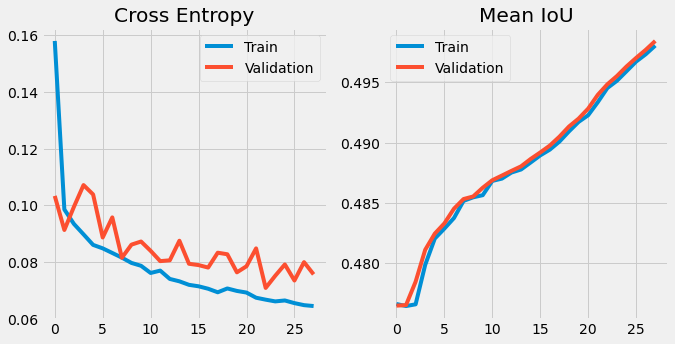

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].set_title('Cross Entropy')
ax[0].plot(hist.loss, label='Train')
ax[0].plot(hist.val_loss, label='Validation')
ax[0].legend()

ax[1].set_title('Mean IoU')
ax[1].plot(hist.dice, label='Train')
ax[1].plot(hist.val_dice, label='Validation')
ax[1].legend();    

## Evaluate
### Test Set Metrics
Now that the model is trained, let's evaluate how it performs against the previously unseen test data.

In [ ]:
model.compile(optim, weighted_loss)

In [45]:
loss = model.evaluate(xtest, ytest_cat, verbose=0)
print(f'Test Data Evaluation Metrics')
print(f'Loss: {round(loss, 4)}')


Test Data Evaluation Metrics
Loss: 0.0755


Our final loss on our training data was 0.066, so this loss is ok. 

Let's see how our model does at predicting masks for images it has never seen before. 

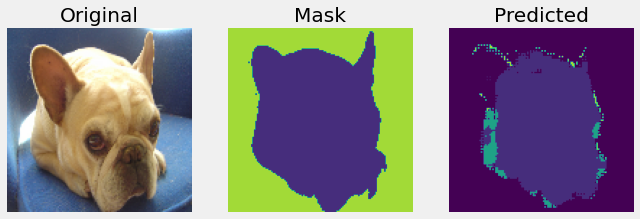

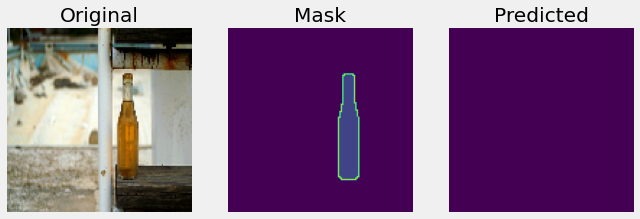

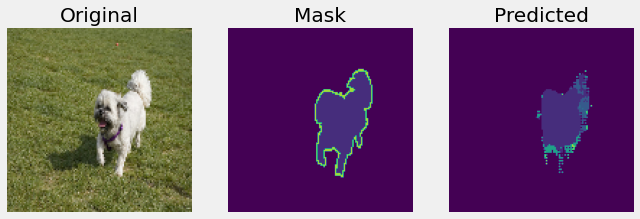

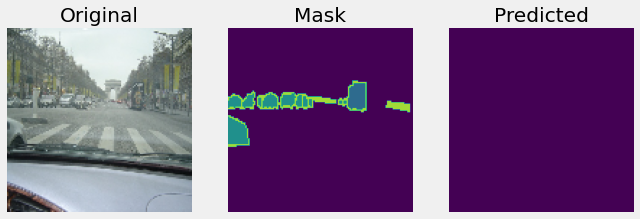

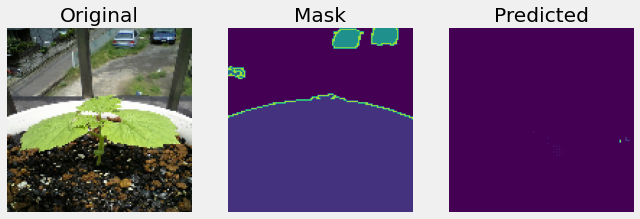

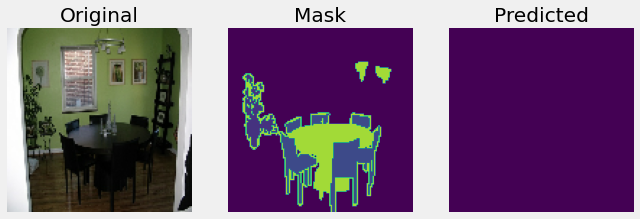

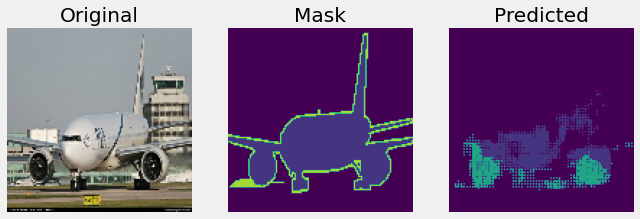

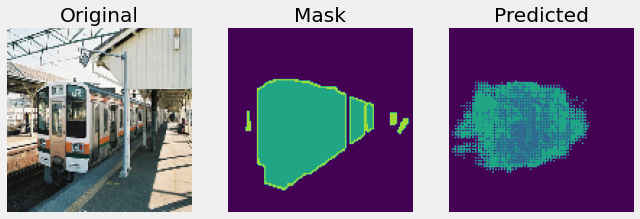

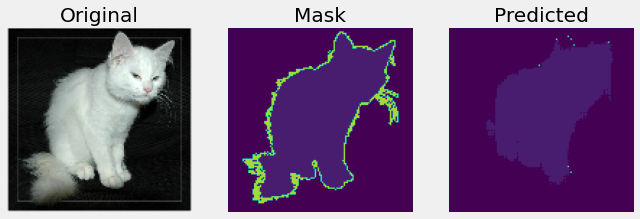

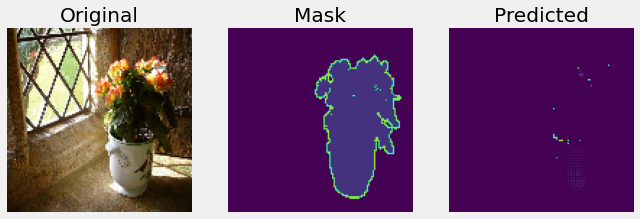

In [46]:
start = 60
end = 70
image_batch, mask_batch = xtest[start:end], ytest_cat[start:end]

preds = model.predict(image_batch)
 
for i in range(0, end-start):
    show_example([image_batch[i], mask_batch[i], preds[i]])

Let's see how the model does at predicting masks for images it was trained on.

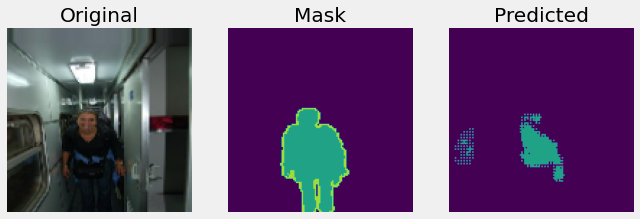

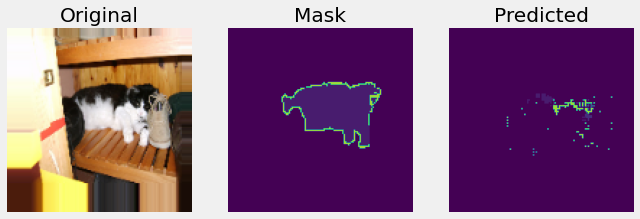

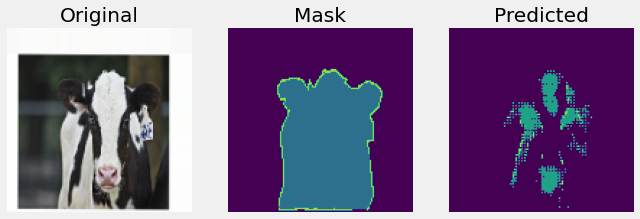

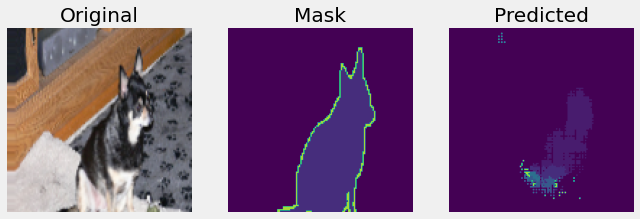

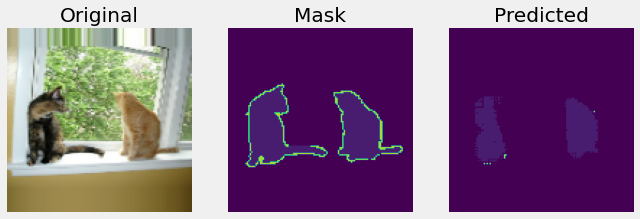

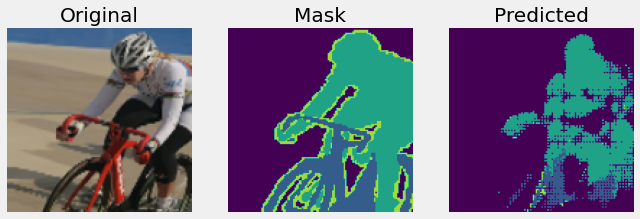

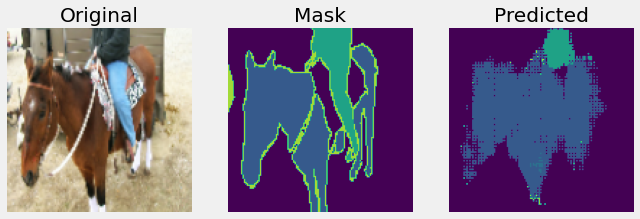

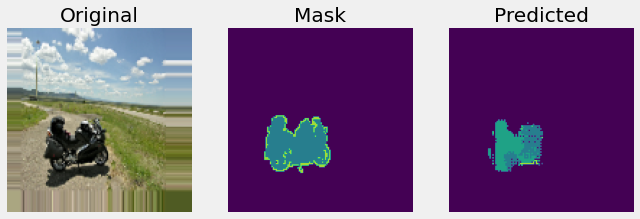

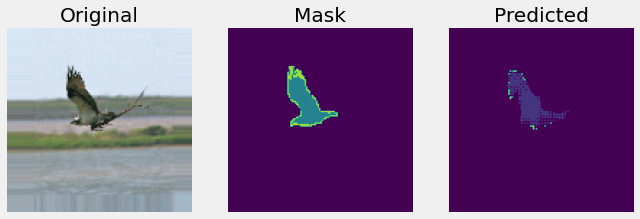

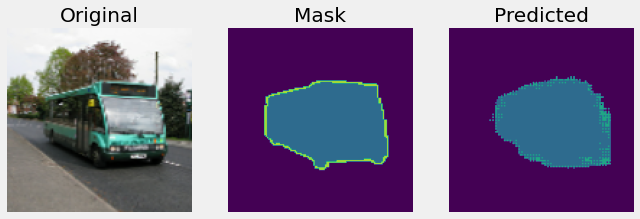

In [47]:
start = 80
end = 90
image_batch, mask_batch = next(train_gen2)

preds = model.predict(image_batch)
 
for i in range(0, end-start):
    show_example([image_batch[i], mask_batch[i], preds[i]])

# Conclusion
Our model could have performed better. I think a major limitation was the number of training images provided. With only ~1600 images, there was only so much we could do to augment the data in order to make training more robust. This explains why we get such better predictions on our training data compared to our test data. 

Additionally, the data was not well balanced. Nearly 30% of the images contained people, which is why the model appears to be somewhat adept at masking images with people. 

The key, which I was not quite able to make work, is defining a loss function which properly weights the classes based upon their frequency. We'd ideally like a loss function that gives little weight to prediction of background pixels, but instead gives a lot of weight to classes that aren't featured as much. 

